In [28]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def print_score(eval_metric, args):
    print(f"{eval_metric.__name__}: {round(eval_metric(*args), 2)}")

In [30]:
from src.utils.metrics import METRICS
METRICS["DISCO"].__name__ = "disco_score"
METRICS["DBCV"].__name__ = "dbcv_score"
METRICS["DCSI"].__name__ = "dcsi_score"
METRICS.keys()

dict_keys(['DISCO', 'DBCV', 'DCSI', 'LCCV', 'VIASCKDE', 'CVDD', 'CDBW', 'CVNN', 'SILHOUETTE', 'S_DBW'])

In [44]:
SAVE_FIG = False

In [32]:
from datasets.density_datasets import Datasets as DensityDatasets
import numpy as np
import matplotlib.pyplot as plt

X, l1 = DensityDatasets.dartboard1.standardized_data_cached

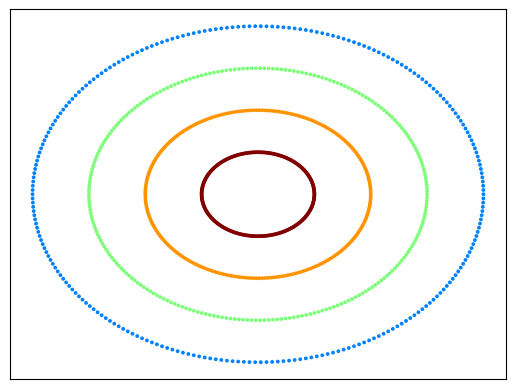

In [33]:
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

plt.scatter(X[:, 0], X[:, 1], s=3, c=l1, vmin=-1, vmax=len(set(l1)) - 1, cmap="jet")
plt.xticks([])
plt.yticks([])
if SAVE_FIG:
    plt.savefig("imgs/motivation/dartboard1.png")
else:
    plt.show()

In [34]:
for eval_metric in METRICS.values():
    print_score(eval_metric, [X, l1])

disco_score: 0.87
dbcv_score: 0.03
dcsi_score: 1.0
lccv_score: 0.68
viasckde_score: 0.48
cvdd_score: 44912.94
cdbw_score: 0.0
cvnn_score: 6.76
silhouette_score: -0.04
sdbw_score: 1.62


In [35]:
from sklearn.cluster import KMeans
np.random.seed(0)
l1_ = KMeans(4).fit_predict(X)

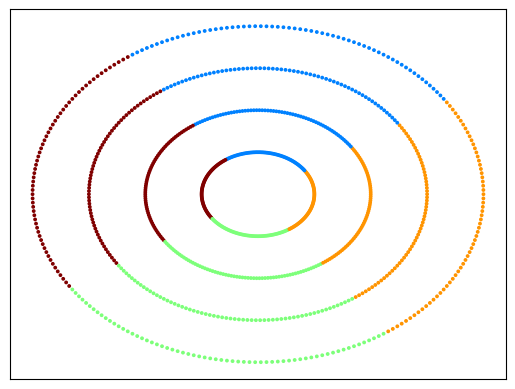

In [36]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=l1_, vmin=-1, vmax=len(set(l1)) - 1, cmap="jet")
plt.xticks([])
plt.yticks([])
if SAVE_FIG:
    plt.savefig("imgs/motivation/dartboard_kmeans.png")
else:
    plt.show()

In [37]:
for eval_metric in METRICS.values():
    print_score(eval_metric, [X, l1_])

disco_score: -0.01
dbcv_score: -0.18
dcsi_score: 0.22
lccv_score: 0.03
viasckde_score: 0.37
cvdd_score: 0.62
cdbw_score: 0.04
cvnn_score: 4.17
silhouette_score: 0.32
sdbw_score: 2.13


In [38]:
from src.utils.data import add_noise

np.random.seed(0)
X_noise, l2 = add_noise(X, l1, 200, 0.2, 0.07)

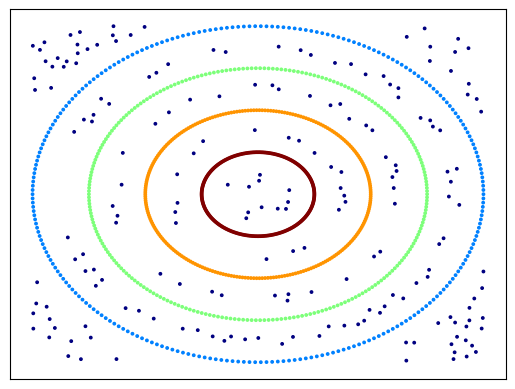

In [39]:
plt.scatter(X_noise[:, 0], X_noise[:, 1], s=3, c=l2, vmin=-1, vmax=len(set(l1)) - 1, cmap="jet")
plt.xticks([])
plt.yticks([])
if SAVE_FIG:
    plt.savefig("imgs/motivation/dartboard_noise.png")
else:
    plt.show()  

In [40]:
for eval_metric in METRICS.values():
    print_score(eval_metric, [X_noise, l2])

disco_score: 0.67
dbcv_score: 0.03
dcsi_score: 1.0
lccv_score: 0.67
viasckde_score: 0.21
cvdd_score: 12015.01
cdbw_score: 0.0
cvnn_score: 6.74
silhouette_score: -0.08
sdbw_score: 1.62


In [41]:
l2_ = l2.copy()
idx = np.where(X[:, 0] > 0)[0]

l2_[idx] = -1

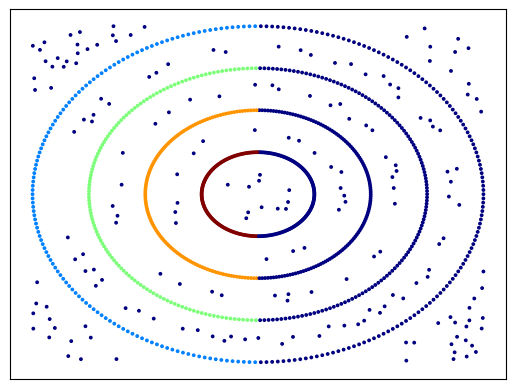

In [42]:
plt.scatter(X_noise[:, 0], X_noise[:, 1], s=3, c=l2_, vmin=-1, vmax=len(set(l1)) - 1, cmap="jet")
plt.xticks([])
plt.yticks([])
if SAVE_FIG:
    plt.savefig("imgs/motivation/dartboard_noise_split.png")
else:
    plt.show()

In [43]:
for eval_metric in METRICS.values():
    print_score(eval_metric, [X_noise, l2_])

disco_score: 0.22
dbcv_score: 0.03
dcsi_score: 1.0
lccv_score: 0.36
viasckde_score: 0.38
cvdd_score: 800.09
cdbw_score: 0.01
cvnn_score: 4.95
silhouette_score: -0.03
sdbw_score: 1.54
